In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
cdpDir = workDir+'cdp_data'
lvl1path = workDir+'CV3_data/LVL1/'

In [19]:
# select imager filter
img_filter = 'F2100W' # 'F2100W','F1500W'

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [20]:
# CV3 MIRM105 (IMG_RAD_18, ramps purposed for non-linearity correction)
if img_filter == 'F2100W':
    filename = lvl1path + 'MIRM105-F2100W-6021152532_1_493_SE_2016-01-21T17h03m07.fits'
elif img_filter == 'F1500W':
    filename = lvl1path + 'MIRM105-F1500W-6021164803_1_493_SE_2016-01-21T17h49m51.fits'

image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [21]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 1
Number of groups/frames per integration: 1000
Total number of frames: 1000
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (1000, 1024, 1032)


In [22]:
image_hdu.close()

<IPython.core.display.Javascript object>


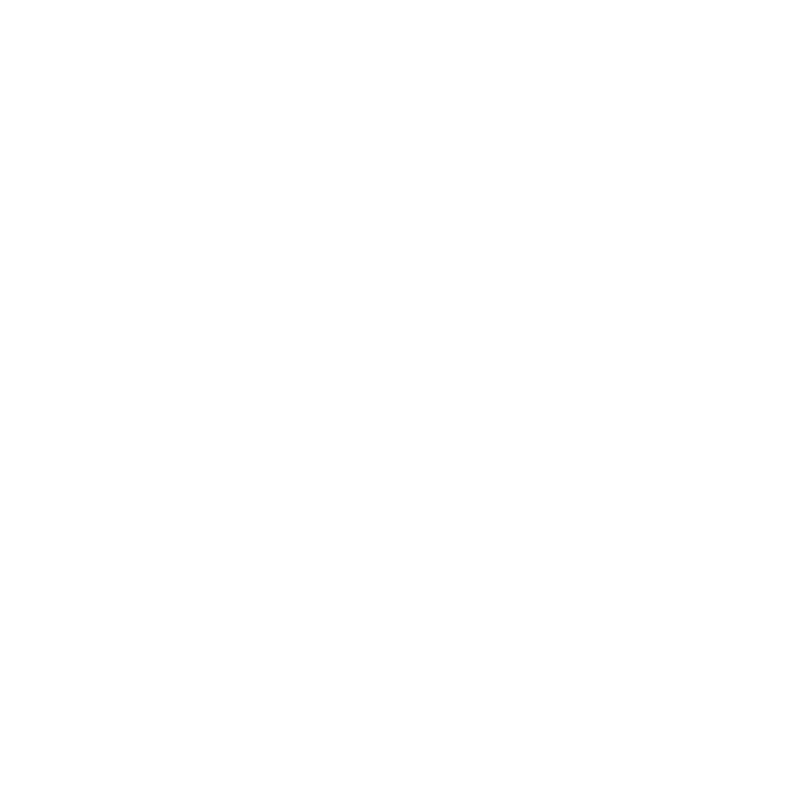

In [23]:
slope_img = (image_data[3,:,:]-image_data[2,:,:])/frame_delta_time

if img_filter == 'F2100W':
    vmin,vmax=20,30
elif img_filter == 'F1500W':
    vmin,vmax=50,140
plt.figure(figsize=(4,4))
plt.imshow(slope_img,vmin=vmin,vmax=vmax)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('Detector image')
plt.tight_layout()

<IPython.core.display.Javascript object>


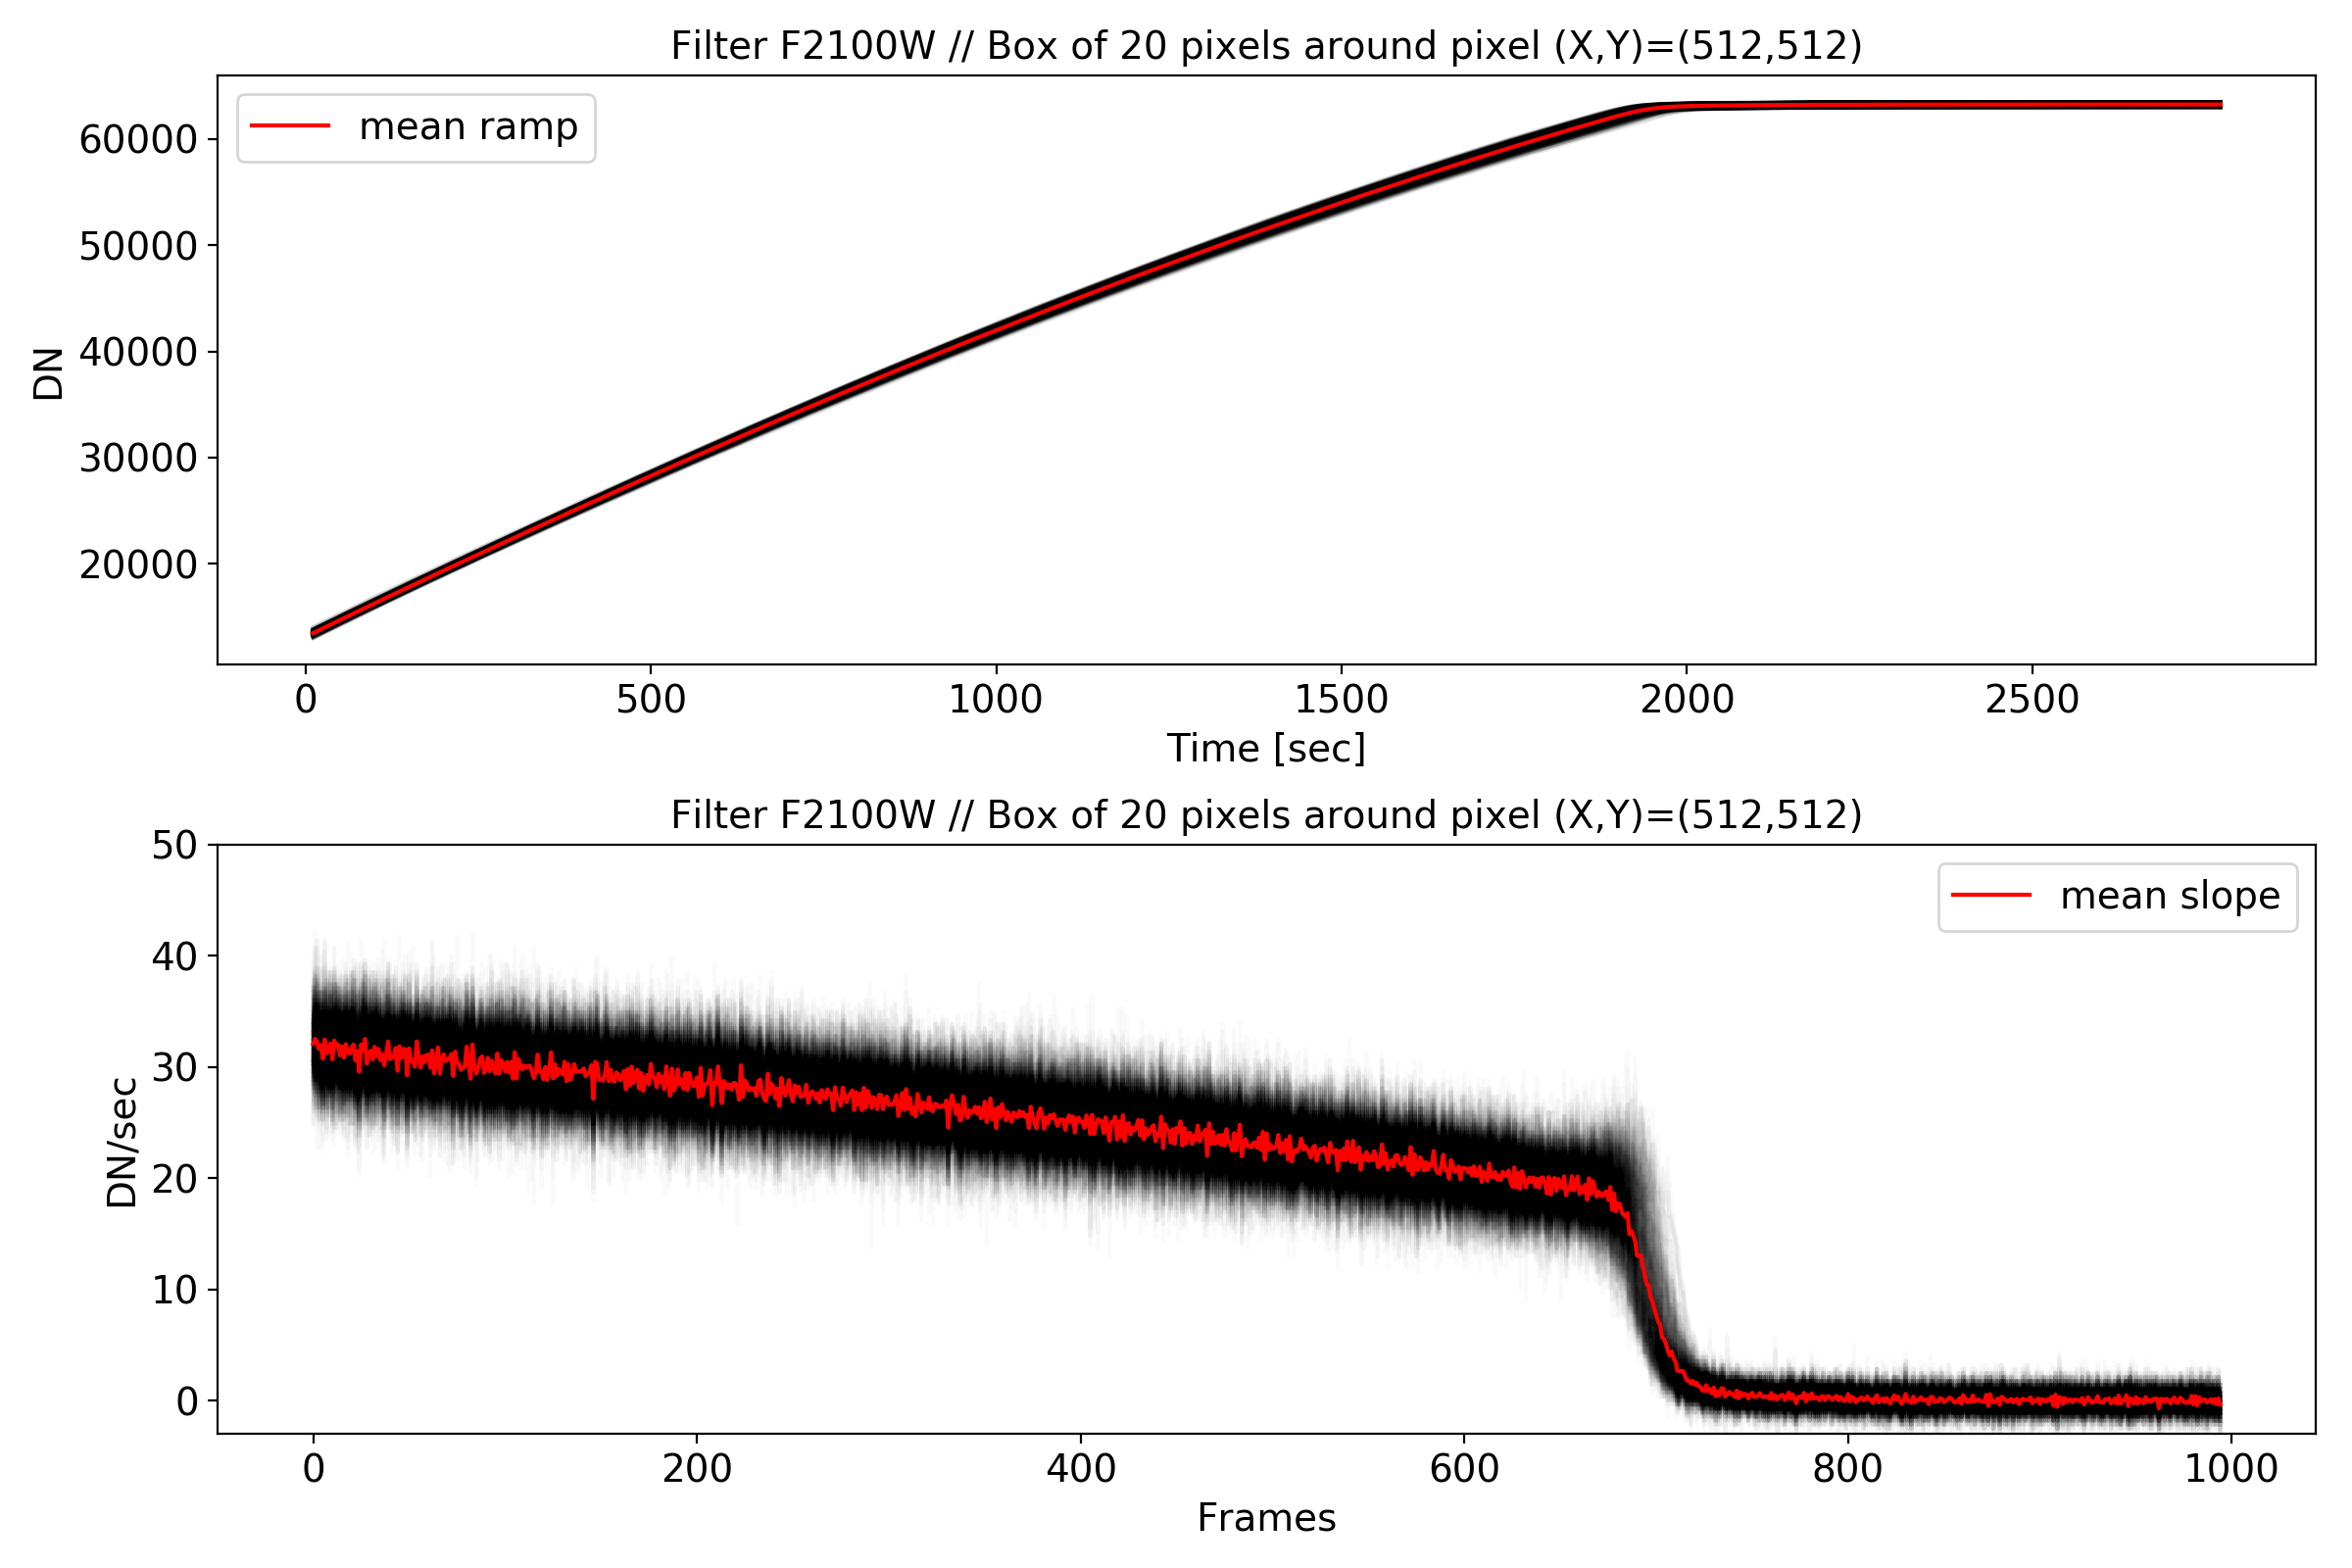

In [26]:
plt.close('all')

time  = np.arange(1,nframes+1)*frame_delta_time

center_pixel = (512,512)
box = 20 # pixels
ramp_arr,slope_arr = [],[]
fig,axs = plt.subplots(2,1,figsize=(12,8))
for ypos in range(center_pixel[0]-box/2,center_pixel[0]+box/2):
    for xpos in range(center_pixel[1]-box/2,center_pixel[1]+box/2):
        tramp = image_data[:,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
        ramp_arr.append(tramp2)
        slope_arr.append(np.diff(tramp2)/frame_delta_time)
        axs[0].plot(time2,tramp2,'k',alpha=0.1)
        axs[1].plot(np.diff(tramp2)/frame_delta_time,'k',alpha=0.02)
ramp_arr = np.array(ramp_arr)
slope_arr = np.array(slope_arr)
axs[0].plot(time2,np.mean(ramp_arr,axis=0),'r',label='mean ramp')
axs[1].plot(np.mean(slope_arr,axis=0),'r',label='mean slope')
axs[0].set_xlabel('Time [sec]',fontsize=14)
axs[0].set_ylabel('DN',fontsize=14)
axs[1].set_xlabel('Frames',fontsize=14)
axs[1].set_ylabel('DN/sec',fontsize=14)
if img_filter == 'F2100W':
    axs[1].set_ylim(-3,50)
elif img_filter == 'F1500W':
    axs[1].set_ylim(-3,150)
for plot in range(2):
    axs[plot].legend(fontsize=14)
    axs[plot].set_title('Filter {} // Box of {} pixels around pixel (X,Y)=({},{})'.format(img_filter,box,center_pixel[1],center_pixel[0]),fontsize=14)
    axs[plot].tick_params(axis='both',labelsize=14)
plt.tight_layout()